#  Project: Using Data to Improve My Quality of Life 


During the pandemic, many of us began to focus on our personal health. I found myself as one among many of my friends who found time to work out, eat better, drink water and mind our business. However, after some of the restrictions were lifted, I found myself slipping back into older, less beneficial habits. This project is one of many in my pursuit of a better work life balance. I collected data on 10 of the youtube influencers I tried during the height of the pandemic and created a plan to craft a more sustainable plan for working out going forward. It was inspired by Thu Vu's Youtube API portfolio project and conversations with Soukina A. about my postpandemic sugar intake and general inactivity. </font>


In [4]:
# Warnings
import warnings
warnings.filterwarnings('ignore')
    
# import libraries and visualization packages
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
import numpy as np
from PIL import Image 
from IPython.display import JSON
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tenic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tenic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Set the API Key and playlist information
api_key = '' # Key not shown here, please generate your own if you would like to implement this project
playlist_name = 'Better Workout'
playlist_description = 'A playlist of the best of my favorite fitness Youtubers'

In [6]:
# Set Channel IDs to 10 of the youtube channels choosing between for working out during the pandemic
channel_ids = ['UCCgLoMYIyP0U56dEhEL1wXQ',
               'UChVRfsT_ASBZk10o0An7Ucg',
               'UCpQ34afVgk8cRQBjSJ1xuJQ',
               'UCTsM1dSAiXqiV5oZjuNw_Bg',
               'UCIJwWYOfsCfz6PjxbONYXSg',
               'UCEQi1ZNJiw3YMRwni0OLsTQ',
               'UCvGEK5_U-kLgO6-AMDPeTUQ',
               'UCjfG0dyMUiqKleUnkX6zBrA',
               'UCRx0HAyAfmcqtrQYK3IITBA',
               'UCyqR7WkL8i1b6xtSssDmW9w',
              ]

In [7]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [8]:
def get_channel_stats(youtube, channel_ids):
    
    """
    Get channel stats
    
    Params:
    ------
    youtube: build object of Youtube API
    channel_ids: list of channel IDs
    
    Returns:
    ------
    dataframe with all channel stats for each channel ID
    
    """
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return(pd.DataFrame(all_data))


In [9]:
def get_video_ids(youtube, playlist_id):
    """
    Get video ids
    
    Params:
    ------
    youtube: build object of Youtube API
    playlist_ids: list of video IDs
    
    Returns:
    ------
    list with all videos within a playlist
    
    """    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [10]:
def get_video_details(youtube, video_ids):
    """
    Get video details
    
    Params:
    ------
    youtube: build object of Youtube API
    video_ids: list of video IDs
    
    Returns:
    ------
    dataframe with all video details for each video ID
    
    """
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [11]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [12]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,MadFit,7150000,753386546,554,UUpQ34afVgk8cRQBjSJ1xuJQ
1,Chloe Ting,23900000,2701471621,364,UUCgLoMYIyP0U56dEhEL1wXQ
2,Natacha Océane,1490000,136597249,215,UUjfG0dyMUiqKleUnkX6zBrA
3,emi wong,5460000,697201308,418,UUvGEK5_U-kLgO6-AMDPeTUQ
4,Whitney Simmons,2080000,221215000,428,UUEQi1ZNJiw3YMRwni0OLsTQ
5,blogilates,6650000,1535957344,1027,UUIJwWYOfsCfz6PjxbONYXSg
6,Bret Contreras Glute Guy,370000,27708134,459,UURx0HAyAfmcqtrQYK3IITBA
7,Pamela Reif,8920000,1480064256,168,UUhVRfsT_ASBZk10o0An7Ucg
8,Lilly Sabri,3790000,493700181,796,UUTsM1dSAiXqiV5oZjuNw_Bg
9,The Fitness Marshall,4070000,770844583,410,UUyqR7WkL8i1b6xtSssDmW9w


In [13]:
# Get Playlist IDs
playlist_id_0 = "UUEQi1ZNJiw3YMRwni0OLsTQ" # Whitney Simmons
playlist_id_1 = "UUvGEK5_U-kLgO6-AMDPeTUQ" # Emi Wong
playlist_id_2 = "UUTsM1dSAiXqiV5oZjuNw_Bg" # Lilly Sabri
playlist_id_3 = "UUjfG0dyMUiqKleUnkX6zBrA" # Natacha Océane
playlist_id_4 = "UURx0HAyAfmcqtrQYK3IITBA" # Brett Contreras Glute Guy
playlist_id_5 = "UUyqR7WkL8i1b6xtSssDmW9w" # The Fitness Marshall
playlist_id_6 = "UUCgLoMYIyP0U56dEhEL1wXQ" # Chloe Ting
playlist_id_7 = "UUpQ34afVgk8cRQBjSJ1xuJQ" # MadFit
playlist_id_8 = "UUIJwWYOfsCfz6PjxbONYXSg" # Blogilates
playlist_id_9 = "UUhVRfsT_ASBZk10o0An7Ucg" # Pamela Reif

In [14]:
# Get video IDs
video_ids_A = get_video_ids(youtube, playlist_id_0)# Whitney Simmons
video_ids_B = get_video_ids(youtube, playlist_id_1)# Emi Wong
video_ids_C = get_video_ids(youtube, playlist_id_2)# Lilly Sabri
video_ids_D = get_video_ids(youtube, playlist_id_3)# Natacha Océane
video_ids_E = get_video_ids(youtube, playlist_id_4)# Brett Contreras Glute Guy
video_ids_F = get_video_ids(youtube, playlist_id_5)# The Fitness Marshall
video_ids_G = get_video_ids(youtube, playlist_id_6)# Chloe Ting
video_ids_H = get_video_ids(youtube, playlist_id_7)# Mad Fit
video_ids_I = get_video_ids(youtube, playlist_id_8)# Blogilates
video_ids_J = get_video_ids(youtube, playlist_id_9)# Pamela Reif

In [15]:
# To determine the number of videos on each channel's default playlist use the following format
# length = len(video_ids_A) 



In [16]:
# Get video details
video_df_A = get_video_details(youtube, video_ids_A)# Whitney Simmons
video_df_B = get_video_details(youtube, video_ids_B)# Emi Wong
video_df_C = get_video_details(youtube, video_ids_C)# Lilly Sabri
video_df_D = get_video_details(youtube, video_ids_D)# Brett Contreras Glute Guy
video_df_E = get_video_details(youtube, video_ids_E)# Brett Contreras Glute Guy
video_df_F = get_video_details(youtube, video_ids_F)# The Fitness Marshall
video_df_G = get_video_details(youtube, video_ids_G)# Chloe Ting
video_df_H = get_video_details(youtube, video_ids_H)# Mad Fit
video_df_I = get_video_details(youtube, video_ids_I)# Blogilates
video_df_J = get_video_details(youtube, video_ids_J)# Pamela Reif

video_df = pd.concat([video_df_A, video_df_B,video_df_C,video_df_D,video_df_E,video_df_F,video_df_G,video_df_H,video_df_I,video_df_J], axis=0)


In [17]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,Uxux1MxDiZ8,Whitney Simmons,ARE YOU READY FOR IT? REVEALING MY NEW GYMSHAR...,GYMSHARK X WHITNEY SIMMONS\n\nLAUNCHING JUNE 2...,"[WHITNEY SIMMONS, GYMSHARK, COLLAB, WHITNEY X ...",2022-06-15T18:00:05Z,245289,11222,None,1688,PT20M31S,hd,false
1,L4gMGVAM0KE,Whitney Simmons,FAVORITES I NEVER WANT TO LIVE WITHOUT | Month...,CURRENT MUST HAVE FAVORITES for Spring!\n\nSHO...,"[WHITNEY SIMMONS, MONTHLY FAVORITES, MONTHLY M...",2022-05-29T19:29:12Z,179620,8952,None,661,PT14M23S,hd,false
2,n2Pu6Iai98o,Whitney Simmons,"GRWM as we FINALLY Talk Wedding Plans, Depress...",Get ready with me as we finally chat all thing...,None,2022-05-18T18:41:29Z,196516,9980,None,1098,PT22M27S,hd,false
3,BJJhsmhpPGE,Whitney Simmons,LET'S CHAT About NEW GYMSHARK! Haul + Try On,Reviewing the BRAND NEW Gymshark Spring Releas...,"[WHITNEY SIMMONS, GYMSHARK, REVIEW, HAUL, TRY ...",2022-03-10T17:19:15Z,242675,8925,None,583,PT12M44S,hd,false
4,RHPIdIAVyT0,Whitney Simmons,EVERYTHING I EAT IN A DAY! Healthy Meal & Snac...,FULL DAY OF EATING!\n\nTRAIN WITH ME on the Al...,"[full day of eating, whitney simmons, everythi...",2022-03-01T16:00:11Z,485789,19328,None,717,PT20M41S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,QN5Nu1aeYyc,Pamela Reif,SEXY ARMS IN 10 MIN / No Equipment | Pamela Reif,This is an INTERMEDIATE workout with options f...,"[workout, training, arm, core, chest, back, up...",2018-03-15T15:08:41Z,10392350,122927,None,1737,PT10M11S,hd,false
164,RqfkrZA_ie0,Pamela Reif,10 MIN BOOTY BURN // No Equipment | Pamela Reif,A quick & intense workout to target your butt....,"[workout, training, butt, glute, booty, ass, l...",2018-01-30T15:12:13Z,49544242,806265,None,16061,PT11M14S,hd,false
165,Q-vuR4PJh2c,Pamela Reif,10 MIN SIXPACK WORKOUT // No Equipment | Pamel...,NO EXCUSES ♥︎ a quick & intense workout to ta...,"[workout, training, abs, sickpack, flat, tummy...",2018-01-08T18:38:38Z,54115490,586081,None,12655,PT10M22S,hd,false
166,iY4hQd24_d0,Pamela Reif,5MIN BOOTY & AB WORKOUT // Yoga Ball | Pamela RF,INTENSE BOOTY & AB EXERCISES // QUICK & EFFEC...,"[5min, 5 minutes, workout, training, abs, ab w...",2016-07-21T20:21:57Z,5257486,97809,None,1066,PT5M36S,hd,false


## Data Pre-processing

In [18]:
# Check Datatypes in Dataframe
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [19]:
# Convert Duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x : isodate.parse_duration(x))
video_df['duration_t'] = video_df['durationSecs'].astype('timedelta64[s]')

# Convert Duration to minutes
video_df['duration_m'] = video_df['durationSecs'].astype('timedelta64[s]')%60

# Compare Duration in minutes to original Duration object code
video_df[['duration_m', 'duration']] 

# Truncate the titles of videos to 25 characters
video_df['title'] = video_df['title'].str [:25] 

# Add tag count
video_df['tag_count'] = video_df['tags'].apply(lambda x:0 if x is None else len(x))

,duration_m,duration
0,31.0,PT20M31S
1,23.0,PT14M23S
2,27.0,PT22M27S
3,44.0,PT12M44S
4,41.0,PT20M41S
...,...,...
163,11.0,PT10M11S
164,14.0,PT11M14S
165,22.0,PT10M22S
166,36.0,PT5M36S


In [20]:
# Convert columns to numerical values
numeric_cols =['viewCount', 'likeCount', 'favouriteCount', 'duration_m','commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric,errors = 'coerce', axis = 1)

In [21]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,durationSecs,duration_t,duration_m,tag_count
0,Uxux1MxDiZ8,Whitney Simmons,ARE YOU READY FOR IT? REV,GYMSHARK X WHITNEY SIMMONS\n\nLAUNCHING JUNE 2...,"[WHITNEY SIMMONS, GYMSHARK, COLLAB, WHITNEY X ...",2022-06-15T18:00:05Z,245289.0,11222.0,NaN,1688.0,PT20M31S,hd,false,0 days 00:20:31,1231.0,31.0,7
1,L4gMGVAM0KE,Whitney Simmons,FAVORITES I NEVER WANT TO,CURRENT MUST HAVE FAVORITES for Spring!\n\nSHO...,"[WHITNEY SIMMONS, MONTHLY FAVORITES, MONTHLY M...",2022-05-29T19:29:12Z,179620.0,8952.0,NaN,661.0,PT14M23S,hd,false,0 days 00:14:23,863.0,23.0,5
2,n2Pu6Iai98o,Whitney Simmons,GRWM as we FINALLY Talk W,Get ready with me as we finally chat all thing...,None,2022-05-18T18:41:29Z,196516.0,9980.0,NaN,1098.0,PT22M27S,hd,false,0 days 00:22:27,1347.0,27.0,0
3,BJJhsmhpPGE,Whitney Simmons,LET'S CHAT About NEW GYMS,Reviewing the BRAND NEW Gymshark Spring Releas...,"[WHITNEY SIMMONS, GYMSHARK, REVIEW, HAUL, TRY ...",2022-03-10T17:19:15Z,242675.0,8925.0,NaN,583.0,PT12M44S,hd,false,0 days 00:12:44,764.0,44.0,6
4,RHPIdIAVyT0,Whitney Simmons,EVERYTHING I EAT IN A DAY,FULL DAY OF EATING!\n\nTRAIN WITH ME on the Al...,"[full day of eating, whitney simmons, everythi...",2022-03-01T16:00:11Z,485789.0,19328.0,NaN,717.0,PT20M41S,hd,false,0 days 00:20:41,1241.0,41.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,QN5Nu1aeYyc,Pamela Reif,SEXY ARMS IN 10 MIN / No,This is an INTERMEDIATE workout with options f...,"[workout, training, arm, core, chest, back, up...",2018-03-15T15:08:41Z,10392350.0,122927.0,NaN,1737.0,PT10M11S,hd,false,0 days 00:10:11,611.0,11.0,46
164,RqfkrZA_ie0,Pamela Reif,10 MIN BOOTY BURN // No E,A quick & intense workout to target your butt....,"[workout, training, butt, glute, booty, ass, l...",2018-01-30T15:12:13Z,49544242.0,806265.0,NaN,16061.0,PT11M14S,hd,false,0 days 00:11:14,674.0,14.0,48
165,Q-vuR4PJh2c,Pamela Reif,10 MIN SIXPACK WORKOUT //,NO EXCUSES ♥︎ a quick & intense workout to ta...,"[workout, training, abs, sickpack, flat, tummy...",2018-01-08T18:38:38Z,54115490.0,586081.0,NaN,12655.0,PT10M22S,hd,false,0 days 00:10:22,622.0,22.0,48
166,iY4hQd24_d0,Pamela Reif,5MIN BOOTY & AB WORKOUT /,INTENSE BOOTY & AB EXERCISES // QUICK & EFFEC...,"[5min, 5 minutes, workout, training, abs, ab w...",2016-07-21T20:21:57Z,5257486.0,97809.0,NaN,1066.0,PT5M36S,hd,false,0 days 00:05:36,336.0,36.0,37


In [22]:
video_df.dtypes

video_id                   object
channelTitle               object
title                      object
description                object
tags                       object
publishedAt                object
viewCount                 float64
likeCount                 float64
favouriteCount            float64
commentCount              float64
duration                   object
definition                 object
caption                    object
durationSecs      timedelta64[ns]
duration_t                float64
duration_m                float64
tag_count                   int64
dtype: object

### Exploratory Data Analysis

<Figure size 864x720 with 0 Axes>

Text(0.5, 1.0, 'Channels with the Best Performing Videos')

Text(0, 0.5, 'Views (Number of Clicks in Millions)')

Text(0.5, 0, 'Channels')

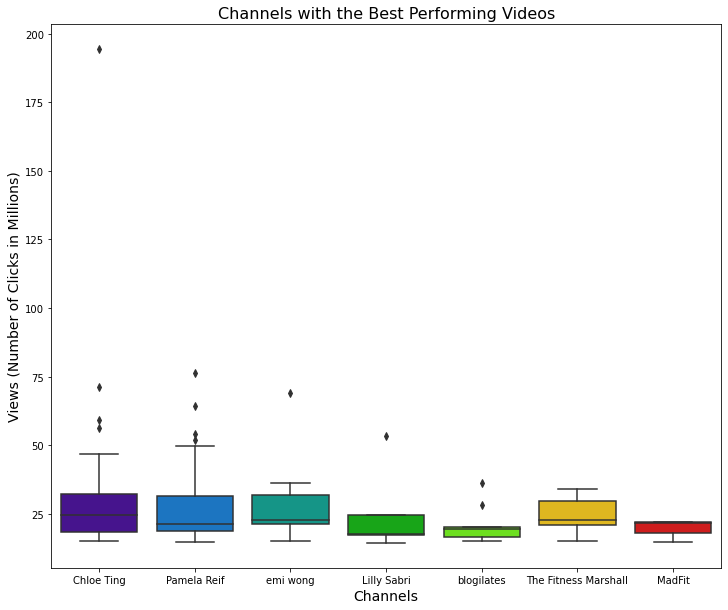

In [23]:
# Create A Box Plot to sort the channels with the best performing videos (The first 5 items had such a large viewCount, I will explore them separately)

# Set Figure Size
plt.figure(figsize = (12,10))

# Set Boxplot parameters
ax = sns.boxplot(data=(video_df).sort_values('viewCount',ascending = False )[1:100],x = 'channelTitle', y = 'viewCount', palette = 'nipy_spectral')
ax.set_title('Channels with the Best Performing Videos', size = 16) 
ax.set_ylabel('Views (Number of Clicks in Millions)', size = 14)
ax.set_xlabel('Channels', size = 14)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.3g}'.format(x/1000000)))
plot = ax.set_xticklabels(ax.get_xticklabels())
#sns.swarmplot(data=(video_df).sort_values('viewCount',ascending = False )[6:100],x = 'channelTitle', y = 'viewCount', palette = 'nipy_spectral')
#plt.show()

<Figure size 864x720 with 0 Axes>

Text(0.5, 1.0, 'Top 5 Performing Videos')

Text(0.5, 0, 'Views (Number of Clicks in Millions)')

Text(0, 0.5, '')

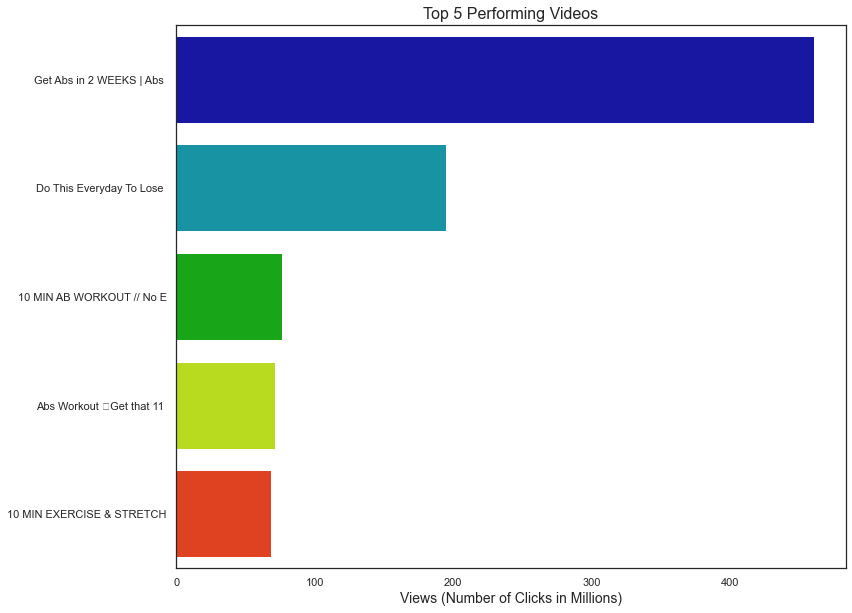

In [24]:
# Create A Box Plot to sort the channels with the best performing videos (The first 5 items had such a large viewCount, I will explore them separately)
plt.figure(figsize = (12,10))  
sns.set(style = 'white')
ax = sns.barplot(data=(video_df).sort_values('viewCount',ascending = False )[0:5],y = 'title', x = 'viewCount',palette = 'nipy_spectral')
ax.set_title('Top 5 Performing Videos', size = 16) # Excluded top 5 videos, will add them to cu
ax.set_xlabel('Views (Number of Clicks in Millions)', size = 14)
ax.set_ylabel('', size = 14)
plot = ax.set_xticklabels(ax.get_xticklabels())
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.3g}'.format(x/1000000)))

## Keyword Frequency
<font size = 3> I wanted a way to visualize Keyword Frequency in Titles so I created a Word Cloud </font>

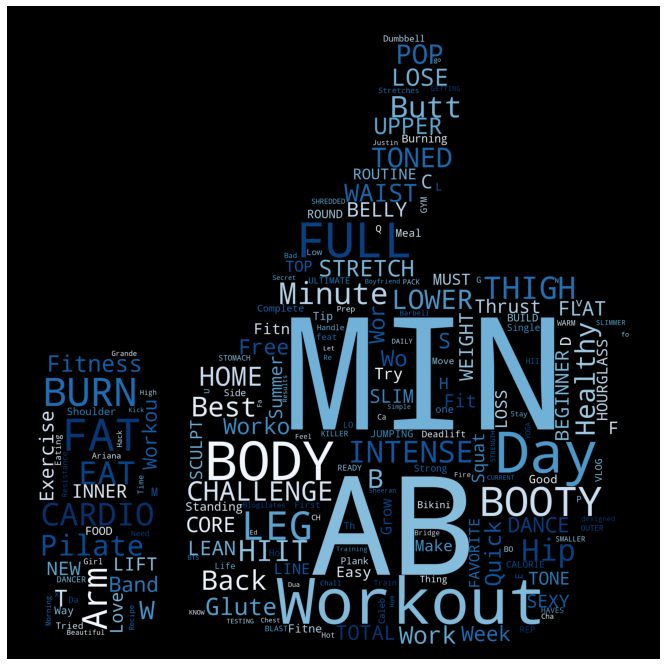

In [25]:
# Create a mask
mask = np.array(Image.open('mask-upvote.png'))
          
# Create stopword list:    
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])
all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

# Generate a word cloud image
def plot_cloud(wordcloud):
    plt.figure(figsize=(14, 12))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 2000, random_state=1, background_color= 'black', 
                      colormap='Blues', collocations=False,mask = mask).generate(all_words_str)
# Display word cloud image
plot_cloud(wordcloud)

# Save word cloud image to file in current directory
cloud =  wordcloud.to_file('wordcloud.png')

In [26]:
import isodate

"""
Exploring Data from Best Performing Videos based on ViewCount 
video_df_G # Chloe Ting
video_df_J # Pamela Reif
video_df_B # Emi Wong
video_df_C # Lilly Sabri
"""

# Convert Duration to seconds
video_df_G['durationSecs'] = video_df_G['duration'].apply(lambda x : isodate.parse_duration(x))
video_df_C['durationSecs'] = video_df_C['duration'].apply(lambda x : isodate.parse_duration(x))
video_df_J['durationSecs'] = video_df_J['duration'].apply(lambda x : isodate.parse_duration(x))
video_df_B['durationSecs'] = video_df_B['duration'].apply(lambda x : isodate.parse_duration(x))

video_df_G['duration_t'] = video_df_G['durationSecs'].astype('timedelta64[s]')
video_df_J['duration_t'] = video_df_J['durationSecs'].astype('timedelta64[s]')
video_df_B['duration_t'] = video_df_B['durationSecs'].astype('timedelta64[s]')
video_df_C['duration_t'] = video_df_C['durationSecs'].astype('timedelta64[s]')


#Set Columns to Numerical Datatypes
numeric_cols =['viewCount', 'likeCount', 'favouriteCount', 'duration_t']

video_df_G[numeric_cols] = video_df_G[numeric_cols].apply(pd.to_numeric,errors = 'coerce', axis = 1)
video_df_J[numeric_cols] = video_df_J[numeric_cols].apply(pd.to_numeric,errors = 'coerce', axis = 1)
video_df_B[numeric_cols] = video_df_B[numeric_cols].apply(pd.to_numeric,errors = 'coerce', axis =1)
video_df_C[numeric_cols] = video_df_C[numeric_cols].apply(pd.to_numeric,errors = 'coerce', axis =1)


#Truncate Video Titles
video_df_G['new_title'] = video_df_G['title'].str[:36]
video_df_J['new_title'] = video_df_J['title'].str[:36]
video_df_B['new_title'] = video_df_B['title'].str[:30]
video_df_C['new_title'] = video_df_C['title'].str[:36]


# When Using combined top videos use the following format
top_videos_df = pd.concat([video_df_G, video_df_J,video_df_B,video_df_C], axis = 0)

'\nExploring Data from Best Performing Videos based on ViewCount \nvideo_df_G # Chloe Ting\nvideo_df_J # Pamela Reif\nvideo_df_B # Emi Wong\nvideo_df_C # Lilly Sabri\n'

In [27]:
top_videos_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,durationSecs,duration_t,new_title
0,85ici-FoXcY,Chloe Ting,Get ABS with this INTENSE 10 Min Ab Workout - ...,Time to work your abs! Brand new 10 min abs ro...,"[abs, ab, core, 10 min abs, home workout, home...",2022-07-11T13:00:07Z,47386.0,4835.0,NaN,375,PT11M10S,hd,false,0 days 00:11:10,670.0,Get ABS with this INTENSE 10 Min Ab
1,DCNfkVg3dps,Chloe Ting,Best HIIT Workout to Lose Weight - Get Abs Cha...,This is episode 1 of the 18 day Get Abs Challe...,"[hiit, workout, 15 min workout, home workout, ...",2022-07-06T13:00:07Z,280286.0,13512.0,NaN,538,PT16M17S,hd,false,0 days 00:16:17,977.0,Best HIIT Workout to Lose Weight - G
2,WzYbPPnvIto,Chloe Ting,How I plan my workouts.. secrets exposed,Secrets out. This is how I plann my workouts. ...,"[chloeting, chloe ting, chloetingchallenge, fi...",2022-06-21T14:00:22Z,206236.0,6296.0,NaN,584,PT11M11S,hd,false,0 days 00:11:11,671.0,How I plan my workouts.. secrets exp
3,FjeuJpjSgKA,Chloe Ting,ouch.. fitness fails you need to avoid,Be safe while working out! Do drop me a like a...,"[chloeting, chloe ting, chloetingchallenge, fi...",2022-06-07T13:00:07Z,190713.0,6413.0,NaN,509,PT8M23S,hd,false,0 days 00:08:23,503.0,ouch.. fitness fails you need to avo
4,l_PpoVPfTzI,Chloe Ting,Full Body Burn - INTENSE but do-able! - Summer...,20 Mins Full Body Burn! Low impacts included s...,"[hiit workout, hiit, full body workout, weight...",2022-06-01T13:00:18Z,962529.0,31965.0,NaN,743,PT20M57S,hd,false,0 days 00:20:57,1257.0,Full Body Burn - INTENSE but do-able
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,MWnGfqJDwd0,Lilly Sabri,10 Minute Intense Ab Workout | Lilly Sabri,,"[fitness, ab, workout, walk through, lilly sab...",2017-08-09T19:51:25Z,51255.0,1035.0,NaN,11,PT15M55S,hd,false,0 days 00:15:55,955.0,10 Minute Intense Ab Workout | Lilly
792,QNVFLjNrkPk,Lilly Sabri,Hourglass Sculpting Workout | Lilly Sabri,PART 1\nThis is the perfect workout for all my...,"[lilly sabri, workout, abs, glutes, bum, belly...",2017-08-02T18:31:40Z,171859.0,3995.0,NaN,96,PT19M22S,hd,false,0 days 00:19:22,1162.0,Hourglass Sculpting Workout | Lilly
793,P-69uWWGipg,Lilly Sabri,Get Your Dream Abs | Correct Core Activation,I HAVE A QUESTION FOR YOU\nWho is struggling t...,"[Abs, fitness, wellbeing, fitness & wellbeing,...",2017-07-19T21:31:10Z,81760.0,2309.0,NaN,60,PT8M16S,hd,false,0 days 00:08:16,496.0,Get Your Dream Abs | Correct Core Ac
794,MKvJe_mWEuM,Lilly Sabri,The Ultimate Legs & Booty Fat Burner | 10 Mins,"The truth is in the name, this really is THE U...","[Spain, Fitness, wellbeing, HIIT, fitness and ...",2017-07-19T21:30:54Z,40213.0,1080.0,NaN,28,PT12M31S,hd,false,0 days 00:12:31,751.0,The Ultimate Legs & Booty Fat Burner


In [28]:
video_df_G #Chloe Ting

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,durationSecs,duration_t,new_title
0,85ici-FoXcY,Chloe Ting,Get ABS with this INTENSE 10 Min Ab Workout - ...,Time to work your abs! Brand new 10 min abs ro...,"[abs, ab, core, 10 min abs, home workout, home...",2022-07-11T13:00:07Z,47386.0,4835.0,NaN,375,PT11M10S,hd,false,0 days 00:11:10,670.0,Get ABS with this INTENSE 10 Min Ab
1,DCNfkVg3dps,Chloe Ting,Best HIIT Workout to Lose Weight - Get Abs Cha...,This is episode 1 of the 18 day Get Abs Challe...,"[hiit, workout, 15 min workout, home workout, ...",2022-07-06T13:00:07Z,280286.0,13512.0,NaN,538,PT16M17S,hd,false,0 days 00:16:17,977.0,Best HIIT Workout to Lose Weight - G
2,WzYbPPnvIto,Chloe Ting,How I plan my workouts.. secrets exposed,Secrets out. This is how I plann my workouts. ...,"[chloeting, chloe ting, chloetingchallenge, fi...",2022-06-21T14:00:22Z,206236.0,6296.0,NaN,584,PT11M11S,hd,false,0 days 00:11:11,671.0,How I plan my workouts.. secrets exp
3,FjeuJpjSgKA,Chloe Ting,ouch.. fitness fails you need to avoid,Be safe while working out! Do drop me a like a...,"[chloeting, chloe ting, chloetingchallenge, fi...",2022-06-07T13:00:07Z,190713.0,6413.0,NaN,509,PT8M23S,hd,false,0 days 00:08:23,503.0,ouch.. fitness fails you need to avo
4,l_PpoVPfTzI,Chloe Ting,Full Body Burn - INTENSE but do-able! - Summer...,20 Mins Full Body Burn! Low impacts included s...,"[hiit workout, hiit, full body workout, weight...",2022-06-01T13:00:18Z,962529.0,31965.0,NaN,743,PT20M57S,hd,false,0 days 00:20:57,1257.0,Full Body Burn - INTENSE but do-able
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,BnYrdALiG2I,Chloe Ting,Festival Lookbook | Festival Outfits,| Music Festival Lookbook 2016 | Outfit Ideas...,"[Festival Lookbook, Coachella Lookbook, Music ...",2016-04-21T13:20:46Z,86511.0,2841.0,NaN,212,PT3M33S,hd,false,0 days 00:03:33,213.0,Festival Lookbook | Festival Outfits
361,7VDR4kF1FGk,Chloe Ting,Spring Outfits 2016 | Another Spring Lookbook,Spring Lookbook 2016 | Spring Outfits 2016 | S...,"[Spring outfits, Spring, Spring outfit ideas, ...",2016-04-07T13:38:23Z,67816.0,2035.0,NaN,165,PT2M54S,hd,false,0 days 00:02:54,174.0,Spring Outfits 2016 | Another Spring
362,3HXmmUGz-Bo,Chloe Ting,Healthy Sweet Snacks | 9 Healthy Snack Ideas,Healthy sweet treats | Healthy Recipes | Low C...,"[Healthy, snacks, ideas, healthy desserts, hea...",2016-03-25T13:00:05Z,261288.0,8353.0,NaN,248,PT8M,hd,false,0 days 00:08:00,480.0,Healthy Sweet Snacks | 9 Healthy Sna
363,-IfUFvvfWEs,Chloe Ting,Spring Lookbook 2016 | Spring Outfits,Spring Lookbook 2016 | Spring Outfits | Spring...,"[Spring lookbook 2016, 2016, spring, lookbook,...",2016-03-17T12:49:24Z,253963.0,5349.0,NaN,294,PT3M23S,hd,false,0 days 00:03:23,203.0,Spring Lookbook 2016 | Spring Outfit


In [41]:
video_df_G['var_ViewCount'] = video_df_G['viewCount']/max(video_df_G['viewCount'])
video_df_G

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,durationSecs,duration_t,new_title,var_ViewCount
0,85ici-FoXcY,Chloe Ting,Get ABS with this INTENSE 10 Min Ab Workout - ...,Time to work your abs! Brand new 10 min abs ro...,"[abs, ab, core, 10 min abs, home workout, home...",2022-07-11T13:00:07Z,47386.0,4835.0,NaN,375,PT11M10S,hd,false,0 days 00:11:10,670.0,Get ABS with this INTENSE 10 Min Ab,0.000103
1,DCNfkVg3dps,Chloe Ting,Best HIIT Workout to Lose Weight - Get Abs Cha...,This is episode 1 of the 18 day Get Abs Challe...,"[hiit, workout, 15 min workout, home workout, ...",2022-07-06T13:00:07Z,280286.0,13512.0,NaN,538,PT16M17S,hd,false,0 days 00:16:17,977.0,Best HIIT Workout to Lose Weight - G,0.000609
2,WzYbPPnvIto,Chloe Ting,How I plan my workouts.. secrets exposed,Secrets out. This is how I plann my workouts. ...,"[chloeting, chloe ting, chloetingchallenge, fi...",2022-06-21T14:00:22Z,206236.0,6296.0,NaN,584,PT11M11S,hd,false,0 days 00:11:11,671.0,How I plan my workouts.. secrets exp,0.000448
3,FjeuJpjSgKA,Chloe Ting,ouch.. fitness fails you need to avoid,Be safe while working out! Do drop me a like a...,"[chloeting, chloe ting, chloetingchallenge, fi...",2022-06-07T13:00:07Z,190713.0,6413.0,NaN,509,PT8M23S,hd,false,0 days 00:08:23,503.0,ouch.. fitness fails you need to avo,0.000414
4,l_PpoVPfTzI,Chloe Ting,Full Body Burn - INTENSE but do-able! - Summer...,20 Mins Full Body Burn! Low impacts included s...,"[hiit workout, hiit, full body workout, weight...",2022-06-01T13:00:18Z,962529.0,31965.0,NaN,743,PT20M57S,hd,false,0 days 00:20:57,1257.0,Full Body Burn - INTENSE but do-able,0.002091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,BnYrdALiG2I,Chloe Ting,Festival Lookbook | Festival Outfits,| Music Festival Lookbook 2016 | Outfit Ideas...,"[Festival Lookbook, Coachella Lookbook, Music ...",2016-04-21T13:20:46Z,86511.0,2841.0,NaN,212,PT3M33S,hd,false,0 days 00:03:33,213.0,Festival Lookbook | Festival Outfits,0.000188
361,7VDR4kF1FGk,Chloe Ting,Spring Outfits 2016 | Another Spring Lookbook,Spring Lookbook 2016 | Spring Outfits 2016 | S...,"[Spring outfits, Spring, Spring outfit ideas, ...",2016-04-07T13:38:23Z,67816.0,2035.0,NaN,165,PT2M54S,hd,false,0 days 00:02:54,174.0,Spring Outfits 2016 | Another Spring,0.000147
362,3HXmmUGz-Bo,Chloe Ting,Healthy Sweet Snacks | 9 Healthy Snack Ideas,Healthy sweet treats | Healthy Recipes | Low C...,"[Healthy, snacks, ideas, healthy desserts, hea...",2016-03-25T13:00:05Z,261288.0,8353.0,NaN,248,PT8M,hd,false,0 days 00:08:00,480.0,Healthy Sweet Snacks | 9 Healthy Sna,0.000568
363,-IfUFvvfWEs,Chloe Ting,Spring Lookbook 2016 | Spring Outfits,Spring Lookbook 2016 | Spring Outfits | Spring...,"[Spring lookbook 2016, 2016, spring, lookbook,...",2016-03-17T12:49:24Z,253963.0,5349.0,NaN,294,PT3M23S,hd,false,0 days 00:03:23,203.0,Spring Lookbook 2016 | Spring Outfit,0.000552


<Figure size 864x720 with 0 Axes>

Text(0.5, 1.0, 'Chloe Ting: Best Performing Videos')

Text(0, 0.5, ' ')

Text(0.5, 0, 'View Count(millions)')

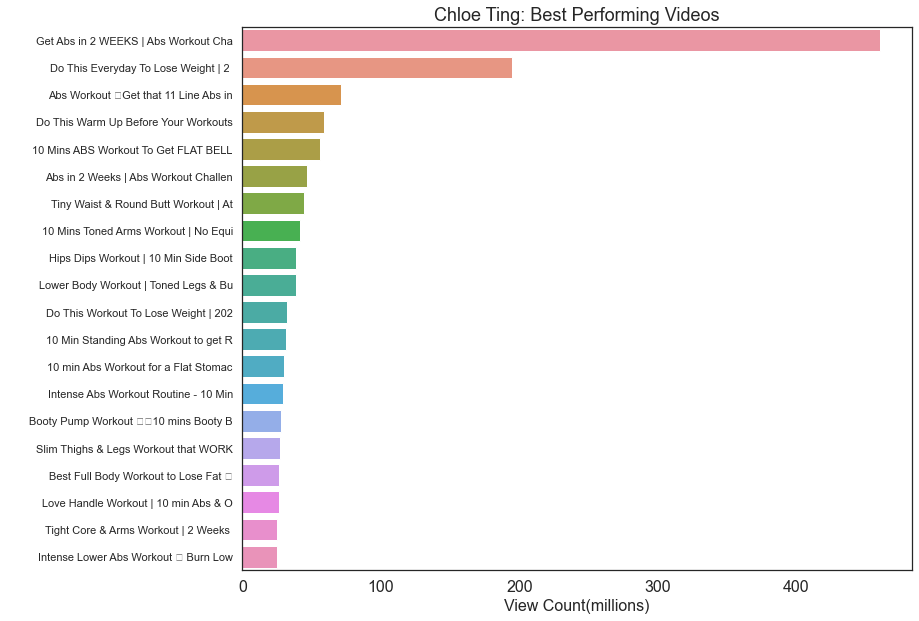

In [52]:
plt.figure(figsize = (12,10))
sns.set_theme(style= "white")

ax = sns.barplot(data=(video_df_G).sort_values('viewCount',ascending = False )[0:20],y = 'new_title', x = 'viewCount')
ax.set_title('Chloe Ting: Best Performing Videos', size = 18)

ax.set_ylabel(' ', size = 18)
ax.set_xlabel("View Count(millions)", size = 16)
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=0, size = 16)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.3g}'.format(x/1000000)))

In [30]:
video_df_J #Pamela Reif

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,durationSecs,duration_t,new_title
0,3LiZGIIXyFc,Pamela Reif,"20 MIN BOOTY, GYM STYLE - Circuit Training wit...",You can do this at home or in the gym ♥︎ This ...,"[workout, training, butt, glute, booty, ass, l...",2022-07-05T01:30:00Z,336085.0,8698.0,NaN,285,PT20M1S,hd,false,0 days 00:20:01,1201.0,"20 MIN BOOTY, GYM STYLE - Circuit Tr"
1,Yw9BKk83Gng,Pamela Reif,10 MIN HIIT HIIT HOORAY - a not dancy (but ver...,Let me trick you - HIIT / Cardio is easy today...,"[workout, training, abs, sickpack, tummy, stom...",2022-06-29T01:30:13Z,537247.0,11980.0,NaN,326,PT10M47S,hd,false,0 days 00:10:47,647.0,10 MIN HIIT HIIT HOORAY - a not danc
2,FAkZLhi30Xw,Pamela Reif,12 MIN BOSS BITCH WORKOUT - shake your booty &...,"Omg, this is so much fun :D Even if you think ...","[workout, training, abs, sickpack, flat, tummy...",2022-06-18T01:30:02Z,1129825.0,28190.0,NaN,1128,PT11M50S,hd,false,0 days 00:11:50,710.0,12 MIN BOSS BITCH WORKOUT - shake yo
3,5rsLU-J8aPM,Pamela Reif,8 MIN HEAD TO TOE STRETCH - after your workout...,a perfect routine for every day ♥︎ Want to cal...,"[workout, training, abs, sickpack, flat, tummy...",2022-06-11T01:30:01Z,485765.0,10714.0,NaN,247,PT9M12S,hd,false,0 days 00:09:12,552.0,8 MIN HEAD TO TOE STRETCH - after yo
4,eH5Ng_9bsUQ,Pamela Reif,10 MIN ELEVATOR BOYS WORKOUT - Fun Full Body /...,5 pretty boys to make our workout life more fu...,"[workout, training, abs, sickpack, flat, tummy...",2022-06-01T01:30:06Z,877989.0,19195.0,NaN,437,PT13M45S,hd,false,0 days 00:13:45,825.0,10 MIN ELEVATOR BOYS WORKOUT - Fun F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,QN5Nu1aeYyc,Pamela Reif,SEXY ARMS IN 10 MIN / No Equipment | Pamela Reif,This is an INTERMEDIATE workout with options f...,"[workout, training, arm, core, chest, back, up...",2018-03-15T15:08:41Z,10392350.0,122927.0,NaN,1737,PT10M11S,hd,false,0 days 00:10:11,611.0,SEXY ARMS IN 10 MIN / No Equipment
164,RqfkrZA_ie0,Pamela Reif,10 MIN BOOTY BURN // No Equipment | Pamela Reif,A quick & intense workout to target your butt....,"[workout, training, butt, glute, booty, ass, l...",2018-01-30T15:12:13Z,49544242.0,806265.0,NaN,16061,PT11M14S,hd,false,0 days 00:11:14,674.0,10 MIN BOOTY BURN // No Equipment |
165,Q-vuR4PJh2c,Pamela Reif,10 MIN SIXPACK WORKOUT // No Equipment | Pamel...,NO EXCUSES ♥︎ a quick & intense workout to ta...,"[workout, training, abs, sickpack, flat, tummy...",2018-01-08T18:38:38Z,54115490.0,586081.0,NaN,12655,PT10M22S,hd,false,0 days 00:10:22,622.0,10 MIN SIXPACK WORKOUT // No Equipme
166,iY4hQd24_d0,Pamela Reif,5MIN BOOTY & AB WORKOUT // Yoga Ball | Pamela RF,INTENSE BOOTY & AB EXERCISES // QUICK & EFFEC...,"[5min, 5 minutes, workout, training, abs, ab w...",2016-07-21T20:21:57Z,5257486.0,97809.0,NaN,1066,PT5M36S,hd,false,0 days 00:05:36,336.0,5MIN BOOTY & AB WORKOUT // Yoga Ball


<Figure size 864x720 with 0 Axes>

Text(0.5, 1.0, 'Pamela Reif : Best Performing Videos')

Text(0.5, 0, 'View Count (millions)')

Text(0, 0.5, ' ')

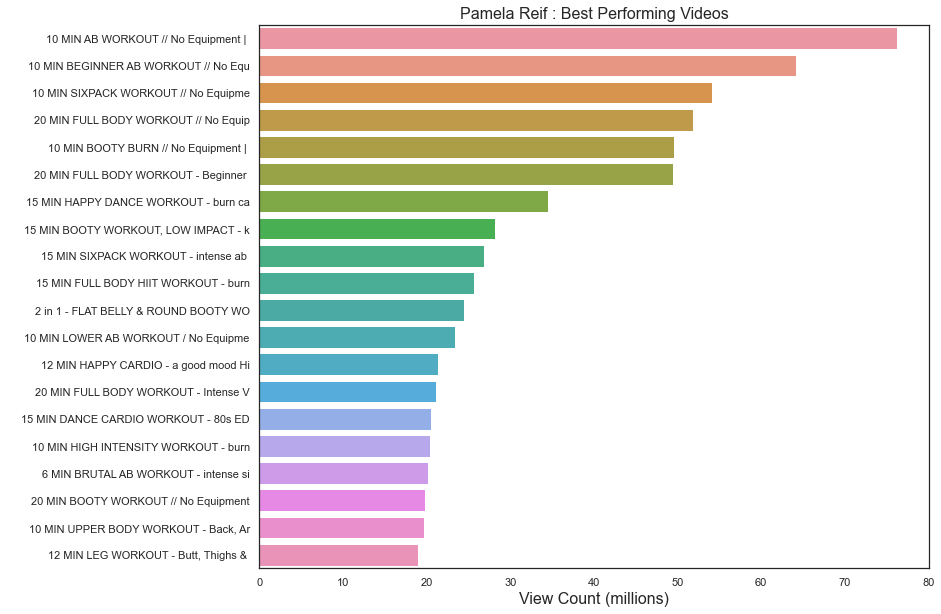

In [31]:
plt.figure(figsize = (12,10))
ax = sns.barplot(data=(video_df_J).sort_values('viewCount',ascending = False )[0:20],y = 'new_title', x = 'viewCount')
ax.set_title('Pamela Reif : Best Performing Videos', size =16)
ax.set_xlabel('View Count (millions)', size = 16)
ax.set_ylabel(' ')

plot = ax.set_xticklabels(ax.get_xticklabels())
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.3g}'.format(x/1000000)))


In [32]:
video_df_B #Emi Wong

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,durationSecs,duration_t,new_title
0,sc0w6wycHUI,emi wong,[SINGAPORE VLOG] First Trip Leaving Hong Kong ...,This video is in collaboration with HotelsComb...,"[singapore vlog, covid travel, leaving hong ko...",2022-07-03T12:18:34Z,72843.0,1544.0,NaN,88,PT14M34S,hd,false,0 days 00:14:34,874.0,[SINGAPORE VLOG] First Trip Le
1,Evy6pj-n1eg,emi wong,15 min Standing Fat Burn HIIT for Weight Loss ...,SUBSCRIBE & TURN ON NOTIFICATIONS FOR NEW VIDE...,"[standing workout, standing hiit, full body hi...",2022-06-09T13:00:07Z,235242.0,7563.0,NaN,172,PT14M56S,hd,false,0 days 00:14:56,896.0,15 min Standing Fat Burn HIIT
2,-hyyVOBzjgI,emi wong,20 min Abs & Legs Standing Workout | 2 Weeks S...,2022 2-Week Flat Belly & Slim Legs Challenge \...,"[abs and legs workout, standing abs workout, s...",2022-05-01T11:18:29Z,492518.0,14075.0,NaN,229,PT21M5S,hd,false,0 days 00:21:05,1265.0,20 min Abs & Legs Standing Wor
3,E0_mEcDReeE,emi wong,Flat Belly & Slim Thighs in 2 Weeks | 30 min ...,2022 2-Week Flat Belly & Slim Legs Challenge \...,"[abs & legs workout, abs workout, legs workout...",2022-04-24T12:31:54Z,633241.0,20192.0,NaN,385,PT29M51S,hd,false,0 days 00:29:51,1791.0,Flat Belly & Slim Thighs in 2
4,HTxclHpjG3k,emi wong,DO CARBS MAKE YOU FAT? Can You Eat Carbs to L...,SUBSCRIBE & TURN ON NOTIFICATIONS FOR NEW VIDE...,"[eat carbs, do carbs make you fat, carbohydrat...",2022-04-20T12:41:39Z,163385.0,4175.0,NaN,111,PT4M7S,hd,false,0 days 00:04:07,247.0,DO CARBS MAKE YOU FAT? Can Yo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,WwqYFnBGjT8,emi wong,Healthy Greek Yogurt Pancakes Recipe for Break...,♡CHECK OUT\nHealthy Vegan Smoothies for Weight...,"[healthy diet, healthy food, nutrition, health...",2017-05-10T12:54:28Z,73876.0,1612.0,NaN,73,PT7M16S,hd,true,0 days 00:07:16,436.0,Healthy Greek Yogurt Pancakes
414,DZ6voLaG9_I,emi wong,10 min Full Body HIIT Workout - FAT BURNING No...,♡SUBSCRIBE & TURN ON NOTIFICATIONS FOR NEW VID...,"[workout, workout video, Fitness, Full body wo...",2017-05-03T12:34:17Z,9566493.0,231014.0,NaN,4733,PT13M,hd,true,0 days 00:13:00,780.0,10 min Full Body HIIT Workout
415,Fo470c993yA,emi wong,MY DIET - What I Eat In A Day to Stay Fit and ...,♡SUBSCRIBE FOR WEEKLY VIDEOS ► http://bit.ly/...,"[Diet, Weight Loss, Healthy Diet, Healthy Life...",2017-04-26T13:28:55Z,151950.0,2256.0,NaN,116,PT15M6S,hd,false,0 days 00:15:06,906.0,MY DIET - What I Eat In A Day
416,p1DJhMy0yCs,emi wong,10 min Intense Ab Workout: No Equipment At Hom...,♡SUBSCRIBE FOR WEEKLY VIDEOS ► http://bit.ly/...,"[workout video, ab workout, ab exercises, ab r...",2017-04-19T14:19:49Z,2376669.0,42778.0,NaN,1290,PT13M55S,hd,true,0 days 00:13:55,835.0,10 min Intense Ab Workout: No


<Figure size 1008x864 with 0 Axes>

Text(0.5, 1.0, 'Emi Wong: Best Performing Videos ')

Text(0, 0.5, ' ')

Text(0.5, 0, 'View Count (million)')

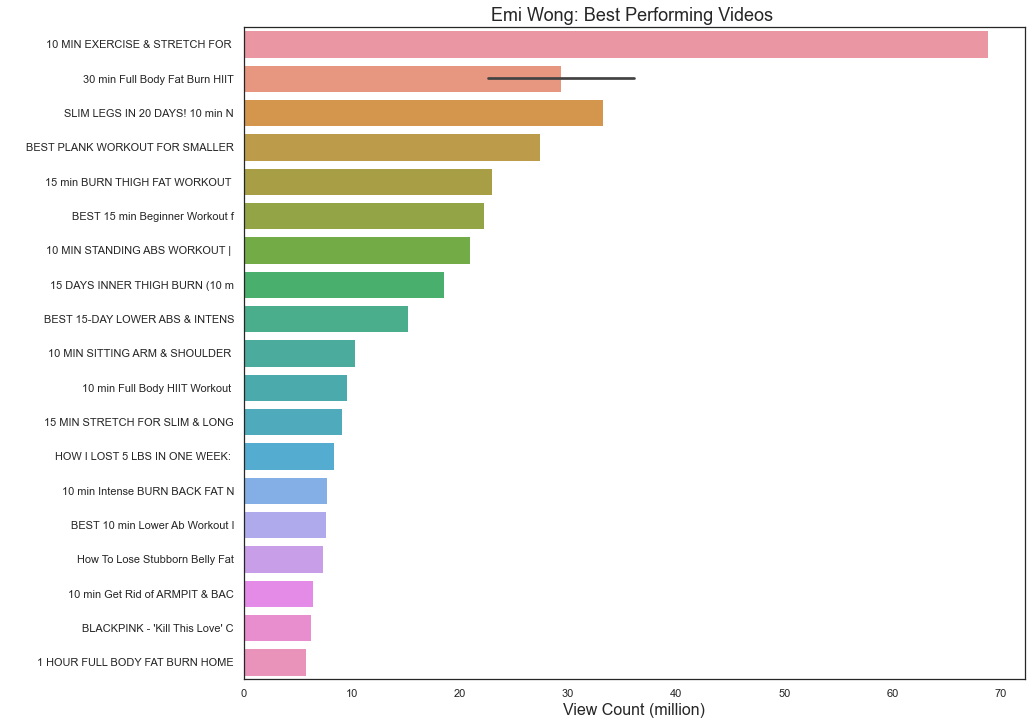

In [33]:
plt.figure(figsize = (14,12))

ax = sns.barplot(data=(video_df_B).sort_values('viewCount',ascending = False )[0:20],y = 'new_title', x = 'viewCount')
ax.set_title('Emi Wong: Best Performing Videos ', size = 18)

ax.set_ylabel(' ', size = 16)
ax.set_xlabel("View Count (million)", size = 16)
plot = ax.set_xticklabels(ax.get_xticklabels())
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.3g}'.format(x/1000000)))

In [34]:
video_df_C #Lilly Sabri

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,durationSecs,duration_t,new_title
0,CX9HU67prfQ,Lilly Sabri,THIS TAKES YOUR WORKOUT TO A WHOLE NEW LEVEL 🤯...,What happens before taking Pre-workout VS afte...,"[home workout, home exercise, workout program,...",2022-07-08T15:00:13Z,33988.0,1210.0,NaN,25,PT6S,hd,false,0 days 00:00:06,6.0,THIS TAKES YOUR WORKOUT TO A WHOLE N
1,UJRqLtctfYQ,Lilly Sabri,Agree or disagree? Smoothies bowls are overrat...,"The most simple, yet delicious recipe from the...","[eat to get results, protein food, protein sna...",2022-07-07T15:00:18Z,45943.0,1940.0,NaN,33,PT5S,hd,false,0 days 00:00:05,5.0,Agree or disagree? Smoothies bowls a
2,oE7QiTnot54,Lilly Sabri,"I had NO choice, but to design my own Mats. He...","Over the last 10 years of teaching classes, I’...","[home workout, home exercise, workout program,...",2022-07-05T15:00:29Z,75984.0,3942.0,NaN,60,PT36S,hd,false,0 days 00:00:36,36.0,"I had NO choice, but to design my ow"
3,aTFGFTB6mIc,Lilly Sabri,TOP 10 SMALLER WAIST EXERCISES (10 day results...,These are the top 10 smaller waist exercises t...,"[home workout, home exercise, from home workou...",2022-06-30T15:00:01Z,202689.0,10280.0,NaN,181,PT6M57S,hd,true,0 days 00:06:57,417.0,TOP 10 SMALLER WAIST EXERCISES (10 d
4,mBSrrTjl7t4,Lilly Sabri,Summer Gymfits Must Haves! OMG you need these ...,1️⃣ - 5️⃣ Which one is your fav? I'm absolutel...,"[home workout, home exercise, workout program,...",2022-06-29T15:00:28Z,48777.0,1567.0,NaN,22,PT2S,hd,false,0 days 00:00:02,2.0,Summer Gymfits Must Haves! OMG you n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,MWnGfqJDwd0,Lilly Sabri,10 Minute Intense Ab Workout | Lilly Sabri,,"[fitness, ab, workout, walk through, lilly sab...",2017-08-09T19:51:25Z,51255.0,1035.0,NaN,11,PT15M55S,hd,false,0 days 00:15:55,955.0,10 Minute Intense Ab Workout | Lilly
792,QNVFLjNrkPk,Lilly Sabri,Hourglass Sculpting Workout | Lilly Sabri,PART 1\nThis is the perfect workout for all my...,"[lilly sabri, workout, abs, glutes, bum, belly...",2017-08-02T18:31:40Z,171859.0,3995.0,NaN,96,PT19M22S,hd,false,0 days 00:19:22,1162.0,Hourglass Sculpting Workout | Lilly
793,P-69uWWGipg,Lilly Sabri,Get Your Dream Abs | Correct Core Activation,I HAVE A QUESTION FOR YOU\nWho is struggling t...,"[Abs, fitness, wellbeing, fitness & wellbeing,...",2017-07-19T21:31:10Z,81760.0,2309.0,NaN,60,PT8M16S,hd,false,0 days 00:08:16,496.0,Get Your Dream Abs | Correct Core Ac
794,MKvJe_mWEuM,Lilly Sabri,The Ultimate Legs & Booty Fat Burner | 10 Mins,"The truth is in the name, this really is THE U...","[Spain, Fitness, wellbeing, HIIT, fitness and ...",2017-07-19T21:30:54Z,40213.0,1080.0,NaN,28,PT12M31S,hd,false,0 days 00:12:31,751.0,The Ultimate Legs & Booty Fat Burner


<Figure size 864x720 with 0 Axes>

Text(0.5, 1.0, 'Lilly Sabri: Best Performing Videos ')

Text(0, 0.5, ' ')

Text(0.5, 0, 'View Count (million)')

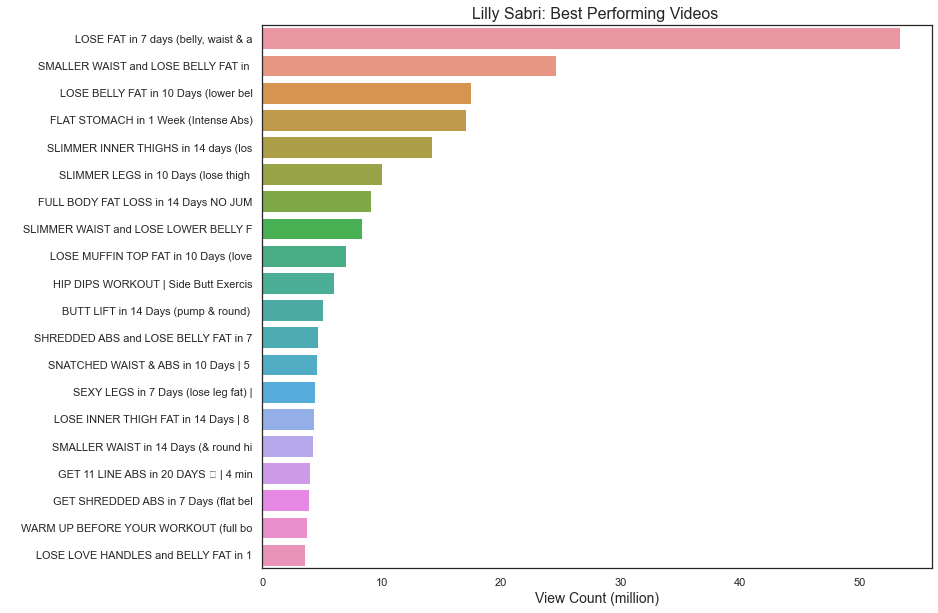

In [35]:
plt.figure(figsize = (12,10))

ax = sns.barplot(data=(video_df_C).sort_values('viewCount',ascending = False )[0:20],y = 'new_title', x = 'viewCount')
ax.set_title('Lilly Sabri: Best Performing Videos ', size = 16)

ax.set_ylabel(' ')
ax.set_xlabel("View Count (million)", size = 14)
plot = ax.set_xticklabels(ax.get_xticklabels())
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.3g}'.format(x/1000000)))

'\nvideo_df_G # Chloe Ting\nvideo_df_J # Pamela Reif\nvideo_df_B # Emi Wong\nvideo_df_C # Lilly Sabri\n\n'

<Figure size 1800x1800 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Chloe Ting: Views as a function of Duration')

Text(0.5, 0, 'Duration (minutes)')

Text(0, 0.5, 'View Count (million)')

<AxesSubplot:>

Text(0.5, 1.0, 'Pamela Reif: Views as a function of Duration')

Text(0.5, 0, 'Duration (minutes)')

Text(0, 0.5, 'View Count (millions)')

<AxesSubplot:>

Text(0.5, 1.0, 'Emi Wong: Views as a function of Duration')

Text(0.5, 0, 'Duration (minutes)')

Text(0, 0.5, 'View Count (millions)')

<AxesSubplot:>

Text(0.5, 1.0, 'Lilly Sabri: Views as a function of Duration')

Text(0.5, 0, 'Duration (minutes)')

Text(0, 0.5, 'View Count (millions)')

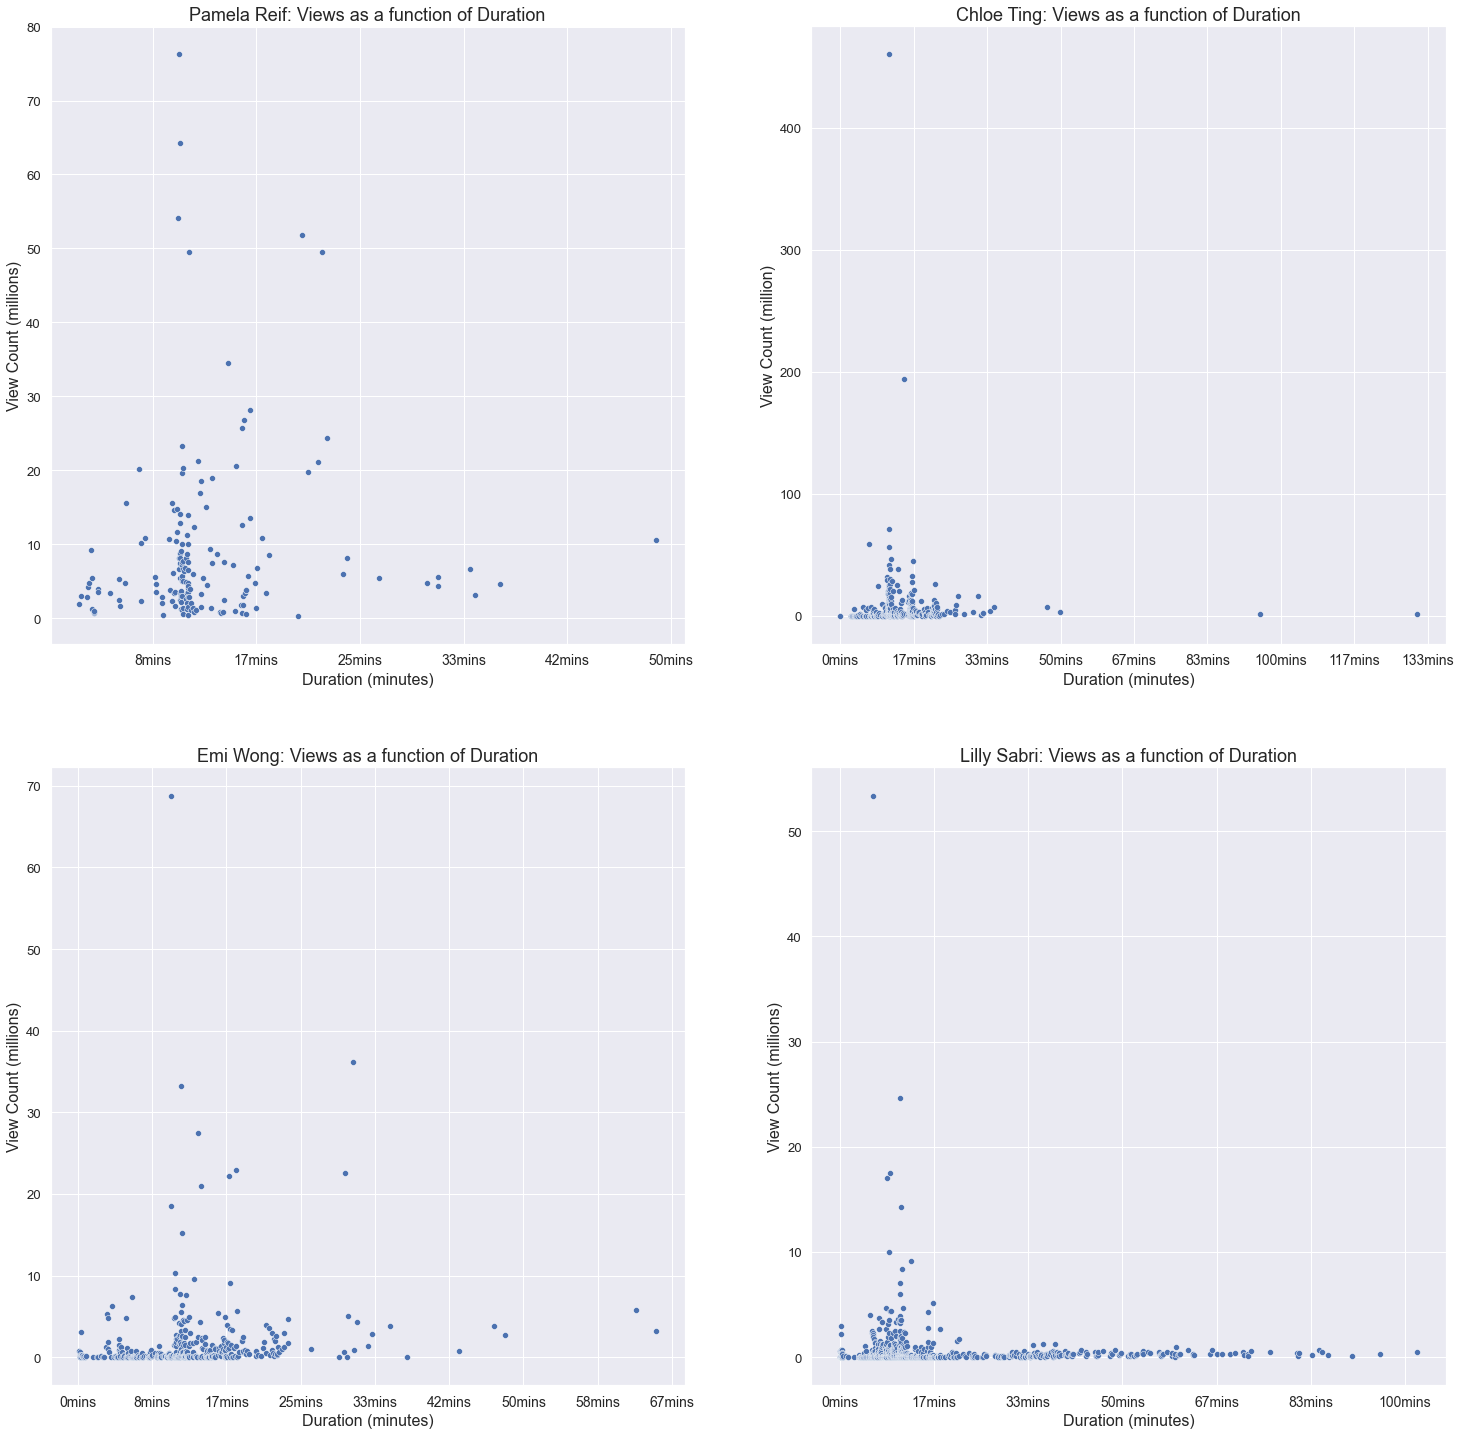

In [36]:
'''
video_df_G # Chloe Ting
video_df_J # Pamela Reif
video_df_B # Emi Wong
video_df_C # Lilly Sabri

'''

sns.set_theme(style="whitegrid")
plt.figure(figsize = (25,25))
sns.set(font_scale=1.2) 
plt.tick_params(axis='both', which='major', labelsize=14)
plt.subplot(2,2,2)
ax = sns.scatterplot(data=(video_df_G).sort_values('duration_t',ascending = True)  ,x = 'duration_t', y = 'viewCount')
ax.set_title('Chloe Ting: Views as a function of Duration', size = 18)
ax.set_xlabel("Duration (minutes)" , size = 16 )
ax.set_ylabel("View Count (million)", size = 16)
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=14)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.3g}'.format(x/1000000) ))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.3g}'.format(round(x/60)) + 'mins'))

plt.subplot(2,2,1)
ax = sns.scatterplot(data=(video_df_J).sort_values('duration_t',ascending = True) ,x = 'duration_t', y = 'viewCount')
ax.set_title('Pamela Reif: Views as a function of Duration', size = 18)
ax.set_xlabel("Duration (minutes)" , size = 16 )
ax.set_ylabel("View Count (millions)", size = 16)
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=14)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.3g}'.format(x/1000000) ))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.3g}'.format(round(x/60)) + 'mins'))

plt.subplot(2,2,3)
ax = sns.scatterplot(data=(video_df_B).sort_values('duration_t',ascending = True) ,x = 'duration_t', y = 'viewCount')
ax.set_title('Emi Wong: Views as a function of Duration', size = 18)
ax.set_xlabel("Duration (minutes)" , size = 16 )
ax.set_ylabel("View Count (millions)", size = 16)
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=14)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.3g}'.format(x/1000000) ))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.3g}'.format(round(x/60)) + 'mins'))


plt.subplot(2,2,4)
#ax.set_xlim(0, 60000000)
ax = sns.scatterplot(data=(video_df_C).sort_values('duration_t',ascending = True) ,x = 'duration_t', y = 'viewCount')
ax.set_title('Lilly Sabri: Views as a function of Duration', size = 18)
ax.set_xlabel("Duration (minutes)" , size = 16 )
ax.set_ylabel("View Count (millions)", size = 16)
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=14)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.3g}'.format(x/1000000) ))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.3g}'.format(round(x/60)) + 'mins'))


In [37]:
sorted_playlist_df = top_videos_df.sort_values('viewCount',ascending = False )[0:20]
sorted_playlist_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,durationSecs,duration_t,new_title
184,2pLT-olgUJs,Chloe Ting,Get Abs in 2 WEEKS | Abs Workout Challenge,Abs Abs Abs! Everyone seems to be asking for a...,"[abs, abs workout, abs exercise, lower abs wor...",2019-08-12T11:45:00Z,460268164.0,8095923.0,NaN,294284,PT11M4S,hd,true,0 days 00:11:04,664.0,Get Abs in 2 WEEKS | Abs Workout Cha
185,2MoGxae-zyo,Chloe Ting,Do This Everyday To Lose Weight | 2 Weeks Shre...,First episode of my new program for this month...,"[workout, daily workout, home workout, full bo...",2019-08-08T11:45:00Z,194459505.0,3845890.0,NaN,146872,PT14M23S,hd,true,0 days 00:14:23,863.0,Do This Everyday To Lose Weight | 2
150,AnYl6Nk9GOA,Pamela Reif,10 MIN AB WORKOUT // No Equipment | Pamela Reif,"inspired by my most popular ""Sixpack Workout"" ...","[workout, training, abs, sickpack, flat, tummy...",2019-10-20T07:00:00Z,76248253.0,795778.0,NaN,19326,PT10M26S,hd,false,0 days 00:10:26,626.0,10 MIN AB WORKOUT // No Equipment |
207,6TmQiugy_qw,Chloe Ting,Abs Workout 🔥Get that 11 Line Abs in 35 days,Want that 11 line abs? It's the 2019 Summer Sh...,"[abs, abs workout, abs exercise, 11 abs, 11 ab...",2019-04-30T11:08:03Z,71279463.0,1478372.0,NaN,43556,PT11M8S,hd,true,0 days 00:11:08,668.0,Abs Workout 🔥Get that 11 Line Abs in
165,jXm0y-csiuE,emi wong,"10 MIN EXERCISE & STRETCH FOR SHOULDERS, NECK ...",SUBSCRIBE & TURN ON NOTIFICATIONS FOR NEW VIDE...,"[collarbone workout, shoulder workout, sexy co...",2020-04-05T12:07:57Z,68807210.0,1450531.0,NaN,21621,PT10M30S,hd,true,0 days 00:10:30,630.0,10 MIN EXERCISE & STRETCH FOR
143,1f8yoFFdkcY,Pamela Reif,10 MIN BEGINNER AB WORKOUT // No Equipment | P...,Ohhhh yes - a BEGINNER ab workout! ♥︎ / Werbun...,"[workout, training, abs, sickpack, flat, tummy...",2020-02-16T08:00:00Z,64215509.0,824706.0,NaN,13820,PT10M30S,hd,false,0 days 00:10:30,630.0,10 MIN BEGINNER AB WORKOUT // No Equ
132,-p0PA9Zt8zk,Chloe Ting,Do This Warm Up Before Your Workouts | Quick W...,It's the new 2020 Summer Shred! Here's a brand...,"[warm up, warm up exercise, warm up exercise b...",2020-05-08T12:32:53Z,59055839.0,565160.0,NaN,7866,PT6M27S,hd,true,0 days 00:06:27,387.0,Do This Warm Up Before Your Workouts
235,UBnfm4s7CRA,Chloe Ting,10 Mins ABS Workout To Get FLAT BELLY IN 30 DA...,This is a 10 mins intense abs workout that wil...,"[abs, abs workout, abs exercise, lower ab work...",2019-01-03T11:48:26Z,56114438.0,1625880.0,NaN,31227,PT11M3S,hd,true,0 days 00:11:03,663.0,10 Mins ABS Workout To Get FLAT BELL
165,Q-vuR4PJh2c,Pamela Reif,10 MIN SIXPACK WORKOUT // No Equipment | Pamel...,NO EXCUSES ♥︎ a quick & intense workout to ta...,"[workout, training, abs, sickpack, flat, tummy...",2018-01-08T18:38:38Z,54115490.0,586081.0,NaN,12655,PT10M22S,hd,false,0 days 00:10:22,622.0,10 MIN SIXPACK WORKOUT // No Equipme
381,ohgLmY19jNg,Lilly Sabri,"LOSE FAT in 7 days (belly, waist & abs) | 5 mi...","Lose belly, waist and abs fat in 7 days with t...","[home workout, home exercise, workout program,...",2020-05-08T16:30:12Z,53385273.0,1520407.0,NaN,49212,PT5M53S,hd,true,0 days 00:05:53,353.0,"LOSE FAT in 7 days (belly, waist & a"


<iframe width="720" height="405" src="https://www.youtube.com/watch_videos?video_ids=Cw-Wt4xKD2s,W4eKVKwf3rQ,I9nG-G4B5Bs" frameborder = "0" allowfullscreen>

In [38]:
target_playlist_id = 'PLC1Z0cuNyOuaWqP1vXXMZkn3T2RjDGBi5'

In [22]:
# Create playlist
video_ids = ['2pLT-olgUJs','2MoGxae-zyo,AnYl6Nk9GOA',
             '6TmQiugy_qw,jXm0y-csiuE','1f8yoFFdkcY',
             '-p0PA9Zt8zk','UBnfm4s7CRA','Q-vuR4PJh2c',
             'ohgLmY19jNg','UBMk30rjy0o','RqfkrZA_ie0',
             'UItWltVZZmE','h8ctkfSx6R0','cIuiQyfKBTg',
             'j64BBgBGNIU','LjmZ1YMOwws','I9nG-G4B5Bs','W4eKVKwf3rQ,Cw-Wt4xKD2s']
def play_playlist(video_ids):
    # Initialize the Chrome driver
    driver = webdriver.Chrome()
    video_url = f'https://www.youtube.com/watch?v={video_ids}'
    webbrowser.open(url)

play_playlist(video_ids)
        

## Outcome
The playlist url becomes: https://www.youtube.com/watch?v=2pLT-olgUJs&list=TLGGtidDM-YJzsExMDA3MjAyMg which I added to my youtube playlist called my_better_workout.

Currently on Day 15 of my 180 day journey.  Next on my list is to increase the varitey of physical activities that I use on my fitness journey.